Bar id — ID батончика в базе данных
Company (Maker-if known) — название компании, изготовившей батончик.
Specific Bean Origin or Bar Name — точное место происхождения какао-бобов.
Broad Bean Origin — название региона, где были выращены какао-бобы.
Company Location — страна, в которой произведён шоколадный батончик.
Bean Type — вид какао-бобов, используемых в батончике.
REF — числовое значение, показывающее, как давно ревью было добавлено в базу. Чем выше значение, тем более свежее ревью.
Review Date — год публикации рецензии.
Cocoa Percent — процент какао в шоколаде.
Rating — оценка батончика фокус-группой.

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

cacao = pd.read_csv('C:\\Users\\prosa\\source\\repos\\skillfactory_rds\\project 2\\cacao_flavors.xls')
cacao.columns = ['bar_id','company','specific_origin','ref','review_date',
                 'cacao_percent','company_location','rating','bean_type','broad_origin']
#display(cacao.head(10))
#cacao.info() 

#print(cacao.bar_id.nunique())
#plt.plot(cacao.bar_id)
cacao.drop(['bar_id'], inplace = True, axis = 1)

# company
cacao.company = cacao.company.apply(lambda x: None if x.strip() == '' else x)
#display(pd.DataFrame(cacao.company.value_counts()))
print("Значений, встретившихся в столбце 'company' более 10 раз:", (cacao.company.value_counts()>10).sum())
#cacao.loc[:, ['company']].info()

# specific_origin
cacao.specific_origin = cacao.specific_origin.apply(lambda x: None if x.strip() == '' else x)
#display(pd.DataFrame(cacao.specific_origin.value_counts()))
print("Значений, встретившихся в столбце 'specific_origin' более 10 раз:", (cacao.specific_origin.value_counts()>10).sum())
#cacao.loc[:, ['specific_origin']].info()

# ref
#cacao.ref.hist()
cacao.ref.describe()

# review_date
#cacao.review_date.hist()
cacao.review_date.describe()

# cocao_percent
cacao.cacao_percent = cacao.cacao_percent.apply(lambda x: float(x.replace('%', '')))
#cacao.cacao_percent.hist()
cacao.cacao_percent.describe()

median = cacao.cacao_percent.median()
IQR = cacao.cacao_percent.quantile(0.75) - cacao.cacao_percent.quantile(0.25)
perc25 = cacao.cacao_percent.quantile(0.25)
perc75 = cacao.cacao_percent.quantile(0.75)
print('\n25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
#cacao.cacao_percent.loc[cacao.cacao_percent.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 16
#                                                                                              , range = (40, 100), 
#                                                                                             label = 'IQR')
#cacao.cacao_percent.loc[cacao.cacao_percent <= 100].hist(alpha = 0.5, bins = 16, range = (40, 100),
#                                                        label = 'Здравый смысл')
#plt.legend();
cacao = cacao.loc[cacao.cacao_percent <= 100]

# company_location
#display(pd.DataFrame(cacao.company_location.value_counts()))
print("Значений, встретившихся в столбце 'company_location' более 10 раз:", (cacao.company_location.value_counts()>10).sum())
#cacao.loc[:, ['company_location']].info()

# rating
#cacao.rating.hist()
#cacao.rating.describe()
median = cacao.rating.median()
IQR = cacao.rating.quantile(0.75) - cacao.rating.quantile(0.25)
perc25 = cacao.rating.quantile(0.25)
perc75 = cacao.rating.quantile(0.75)
print('\n25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
#cacao.rating.loc[cacao.rating.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 10), 
#                                                                                             label = 'IQR')
#plt.legend();

cacao = cacao.loc[cacao.rating.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]

# bean_type
cacao.bean_type = cacao.bean_type.apply(lambda x: None if pd.isnull(x) else None if x == 'nan' 
                      else x if '(' not in x else x[:x.find('(')].strip())
#display(pd.DataFrame(cacao.bean_type.value_counts()))
print("\nЗначений, встретившихся в столбце 'bean_type' более 10 раз:", (cacao.bean_type.value_counts()>10).sum())
print("Уникальных значений 'bean_type':", cacao.bean_type.nunique())
#cacao.loc[:, ['bean_type']].info()

# broad_origin
def fix_countries(x):
    if pd.isnull(x):
        return x
    if x == 'nan':
        return None
    x = x.replace(' ', '')
    x = x.replace('/', ',') # Venezuela/ Ghana
    x = x.replace('&', ',')
    if '(' in x:
        x = x[:x.find('(')] #Peru(SMartin,Pangoa,nacional)
    x = x.replace('Guat.', 'Guatemala')
    
    if 'Ven' in x and 'Venezuela' not in x:
        x = x.replace('Venez', 'Venezuela') #Venez,Africa,Brasil,Peru,Mex
        x = x.replace('Ven,', 'Venezuela,') #Ven, Trinidad, Ecuador
        x = x.replace('Ven.', 'Venezuela') #Ven., Trinidad, Mad.
        if 'Ven' in x and 'Venezuela' not in x:
            x = x.replace('Ven', 'Venezuela')
        
    x = x.replace('Dom.Rep.', 'DomincanRepublic')
    x = x.replace('DR', 'DomincanRepublic')
    x = x.replace('Dom.Rep', 'DomincanRepublic')
    x = x.replace('D.R.', 'DomincanRepublic')
    x = x.replace('DominicanRep.', 'DomincanRepublic')
    x = x.replace('Domin.Rep', 'DomincanRepublic')
    x = x.replace('Domin.Re', 'DomincanRepublic')
    
    if 'Jam' in x and 'Jamaica' not in x:
        x = x.replace('Jam', 'Jamaica')
        
    if 'Mad.' in x and 'Madagascar' not in x:
        x = x.replace('Mad.', 'Madagascar')
    elif 'Mad' in x and 'Madagascar' not in x:
        x = x.replace('Mad', 'Madagascar')
    elif 'Ma' in x and 'Madagascar' not in x:
        x = x.replace('Ma', 'Madagascar')
        
    if 'Hait' in x and 'Haiti' not in x:
        x = x.replace('Hait', 'Haiti')
        
    if 'Per' in x and 'Peru'  not in x:
        x = x.replace('Per', 'Peru')
    
    x = x.replace('Nic.', 'Nicaragua')

    x = x.replace('Gre.', 'Grenada')
    
    x = x.replace('PNG', 'PapuaNewGuinea')
    
    if 'Mex' in x and 'Mexico' not in x:
        x = x.replace('Mex', 'Mexico')
        
    x = x.replace('Haw.', 'Hawaii')
    
    x = x.replace('Ecuad.', 'Ecuador')
    x = x.replace('Ecu.', 'Ecuador')
    
    return x
cacao.broad_origin = cacao.broad_origin.apply(fix_countries).sort_values()
#display(pd.DataFrame(cacao.broad_origin.value_counts()))
print("\nЗначений, встретившихся в столбце 'broad_origin' более 10 раз:", (cacao.broad_origin.value_counts()>10).sum())
print("Уникальных значений 'broad_origin':", cacao.broad_origin.nunique())
#cacao.loc[:, ['broad_origin']].info()

Значений, встретившихся в столбце 'company' более 10 раз: 30
Значений, встретившихся в столбце 'specific_origin' более 10 раз: 15

25-й перцентиль: 70.0, 75-й перцентиль: 75.0, IQR: 5.0,  Границы выбросов: [62.5, 82.5].
Значений, встретившихся в столбце 'company_location' более 10 раз: 22

25-й перцентиль: 3.0, 75-й перцентиль: 3.5, IQR: 0.5,  Границы выбросов: [2.25, 4.25].

Значений, встретившихся в столбце 'bean_type' более 10 раз: 6
Уникальных значений 'bean_type': 22

Значений, встретившихся в столбце 'broad_origin' более 10 раз: 26
Уникальных значений 'broad_origin': 94


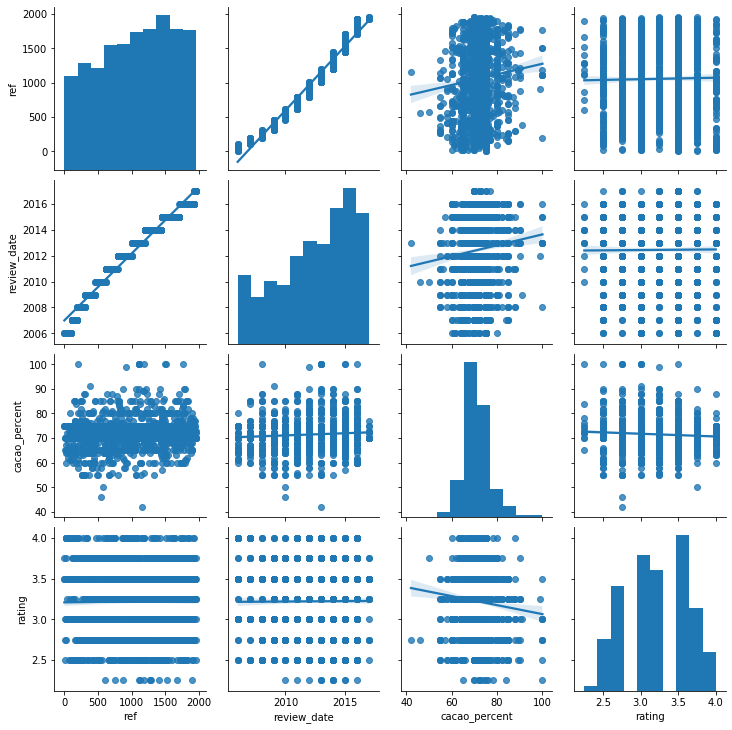

In [59]:
sns.pairplot(cacao, kind = 'reg')
cacao.corr()

cacao.drop(['ref'], inplace = True, axis = 1)

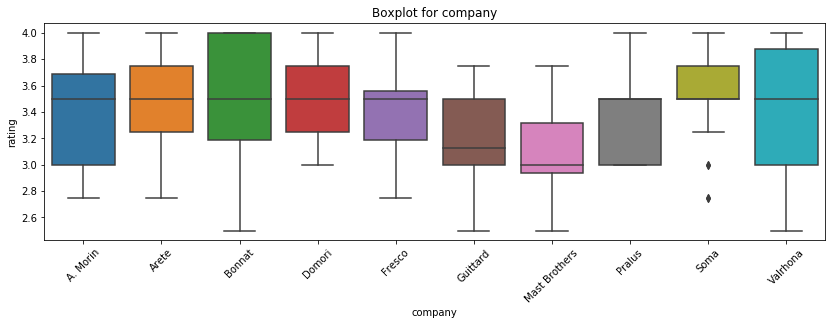

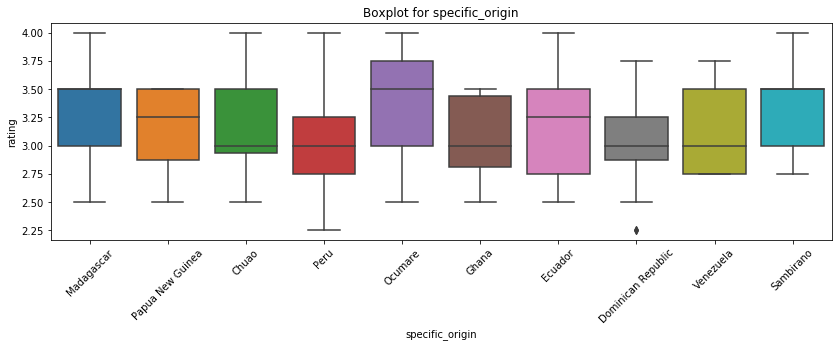

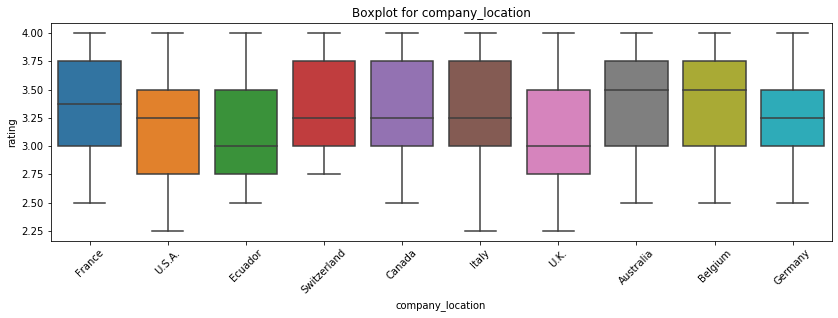

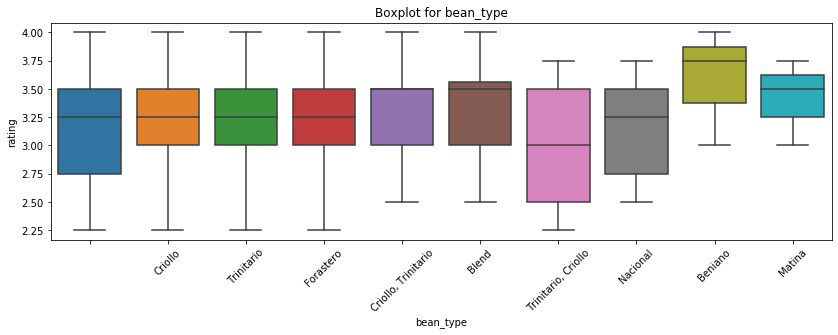

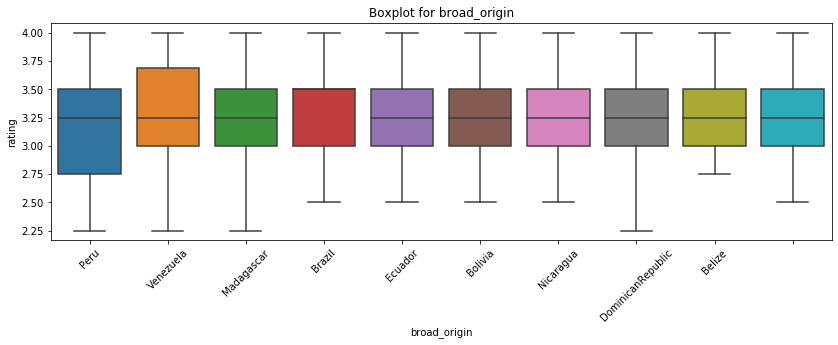

In [60]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='rating', 
                data=cacao.loc[cacao.loc[:, column].isin(cacao.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

for col in ['company', 'specific_origin', 'company_location', 'bean_type', 'broad_origin']:
    get_boxplot(col)

In [61]:
def get_stat_dif(column):
    cols = cacao.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(cacao.loc[cacao.loc[:, column] == comb[0], 'rating'], 
                        cacao.loc[cacao.loc[:, column] == comb[1], 'rating']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
for col in ['company', 'specific_origin', 'company_location', 'bean_type', 'broad_origin']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки company
Найдены статистически значимые различия для колонки specific_origin
Найдены статистически значимые различия для колонки company_location


In [63]:
cacao_for_model = cacao.loc[:, ['company', 'specific_origin', 'company_location', 'review_date', 'cacao_percent']]
cacao_for_model.head()

,company,specific_origin,company_location,review_date,cacao_percent
1,A. Morin,Kpime,France,2015,70.0
3,A. Morin,Akata,France,2015,70.0
4,A. Morin,Quilla,France,2015,70.0
5,A. Morin,Carenero,France,2014,70.0
6,A. Morin,Cuba,France,2014,70.0
